# Google Analytics Revenue Prediction

## Model Selection - Classification

**Environment**

In [80]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
import eli5


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
from myfunctions import *

**Import Dataframe**

In [3]:
df = pd.read_csv("data/df5-1.csv", low_memory=False)

In [4]:
df.shape

(903455, 50)

In [5]:
df.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,newConversion
0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.487985,0
1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.305608,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.413922,0
3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.174982,0
4,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,1,0,1,0,1,0.417494,0


In [6]:
df.columns

Index(['channel_direct', 'channel_organic', 'channel_other', 'channel_paid',
       'browser_android', 'browser_chrome', 'browser_firefox',
       'browser_microsoft', 'browser_other', 'cat_desktop', 'cat_mobile',
       'os_Android', 'os_Macintosh', 'os_Windows', 'os_iOS', 'continet_Africa',
       'continet_Americas', 'continet_Asia', 'continet_Europe',
       'continet_Oceania', 'ad_GoogleMerchandiseCollection', 'ad_NoAd',
       'network_Google Search', 'network_NoAdWords', 'campaign_AW',
       'campaign_Data Share', 'campaign_NoCampaign', 'medium_affiliate',
       'medium_cpc', 'medium_cpm', 'medium_none', 'medium_organic',
       'medium_other', 'referral_Google', 'referral_Home',
       'referral_NoReferral', 'referral_Youtube', 'source_Google',
       'source_Googleplex', 'source_Youtube', 'source_direct', 'visitNumber',
       'deviceIsMobile', 'totalsBounces', 'totalsNewVisits', 'totalsPageviews',
       'adwordsClickGclId', 'trafficSourceIsTrueDirect', 'newRandom',
       

### Model Selection

In the model selection process I will take into account:<br>
    1.- It is a binaty classification problem<br>
    2.- The data is Sparse<br>
    3.- The target is very unbalanced (1,29% vs 98,71)<br>
    4.- There is a lot of data 903455 rows and 48 columns<br>

**CONCLUSIONS:**<br>
1.- I'll use a decision tree<br>
2.- I'll try to balance the classes down sampling the data<br>
3.- I'll use Under ROC Curve (AUROC) as metric<br>

### Down sampling the dataframe

I'll separate observations from each class into different DataFrames.


In [7]:
# Separate majority and minority classes
df_majority = df[df.newConversion==0]
df_minority = df[df.newConversion==1]

In [8]:
df_majority.shape

(891940, 50)

In [9]:
df_minority.shape

(11515, 50)

I'll resample the majority class without replacement, setting the number of samples to match that of the minority class.


In [10]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=11515,     # to match minority class
                                 random_state=123) # reproducible results
 

I'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

In [11]:
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [12]:
df_downsampled['newConversion'].value_counts()

1    11515
0    11515
Name: newConversion, dtype: int64

In [13]:
df_downsampled.shape

(23030, 50)

In [14]:
df_downsampled.isnull().sum().sum()

0

In [15]:
df_downsampled.to_csv("data/df5_1-downsampled.csv",index=False)

### Classification Tree: Random Forrest

#### Split dataframe

In [16]:
X = df_downsampled.iloc[:,:-1]
y = df_downsampled.iloc[:,-1:]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.2, random_state=10)

#### Search Grid Cross Validation

In [18]:
rfc = RandomForestClassifier(random_state=10)

In [19]:
#Current parameters of Random Forrest Classifier
print(rfc.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


I'll use the following parameters to hypertune the model

n_estimators = number of trees in the foreset<br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
bootstrap = method for sampling data points (with or without replacement)<br>
criterion = the function to measure the quality of a split

In [22]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'bootstrap' : [True, False],
    'criterion': ['gini', 'entropy']   
}

In [23]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=8)

In [24]:
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   1.8s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.960, total=   1.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.951, total=   1.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.954, total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.959, total=   1.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [25]:
CV_rfc.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 100}

In [26]:
rfc_best=RandomForestClassifier(random_state=10, max_features=CV_rfc.best_params_['max_features'], n_estimators=CV_rfc.best_params_['n_estimators'], max_depth=CV_rfc.best_params_['max_depth'], criterion=CV_rfc.best_params_['criterion'], bootstrap=CV_rfc.best_params_['bootstrap'])


In [27]:
rfc_best.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [28]:
y_pred_train=rfc_best.predict(X_train)

In [29]:
y_pred=rfc_best.predict(X_test)

In [30]:
f1_score(y_train, y_pred_train)

0.9622930879475382

In [31]:
f1_score(y_test, y_pred)

0.9592569136584337

In [32]:
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[8613,  599],
       [ 114, 9098]])

In [33]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2141,  162],
       [  31, 2272]])

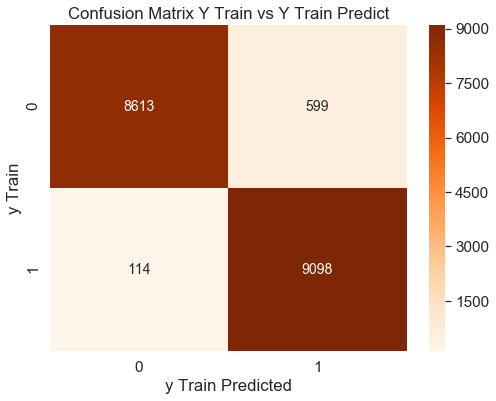

In [34]:
data = confusion_matrix(y_train, y_pred_train)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Train'
df_cm.columns.name = 'y Train Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Train vs Y Train Predict")
plt.show()

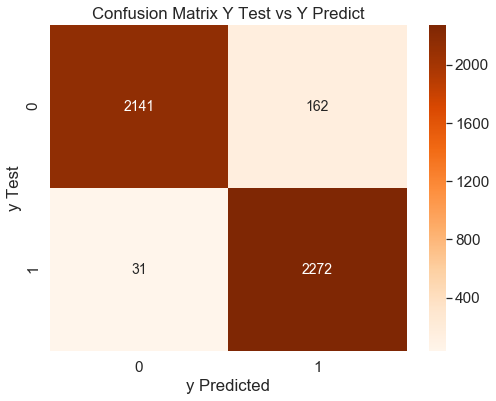

In [35]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Test'
df_cm.columns.name = 'y Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Test vs Y Predict")
plt.show()

In [36]:
roc_auc_score(y_test, y_pred)

0.9580981328701694

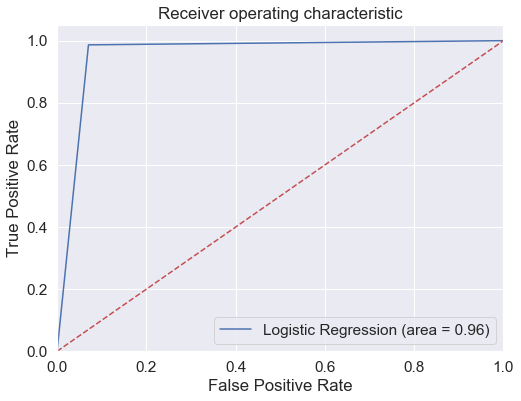

In [37]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Feature Importance

In [38]:
rfc_best.feature_importances_

array([4.53552333e-04, 8.51773794e-04, 1.60543479e-02, 1.61267639e-04,
       6.87184651e-05, 1.98514295e-03, 2.12853359e-04, 2.63438847e-04,
       1.58009035e-04, 5.07793611e-03, 5.77894288e-03, 1.35789150e-03,
       5.15457578e-03, 1.35650780e-03, 1.53244556e-03, 1.99029880e-04,
       8.61530208e-02, 2.38709299e-02, 2.12361725e-02, 3.75327168e-04,
       1.06838135e-04, 8.45952205e-05, 2.75507126e-04, 2.18094985e-04,
       2.84247103e-04, 6.43730015e-04, 2.96427051e-04, 5.82159413e-04,
       1.51182677e-04, 1.54923201e-04, 4.96639737e-04, 7.00936931e-04,
       1.44692163e-05, 2.85418174e-04, 3.33907893e-02, 6.11654148e-03,
       2.97419219e-02, 2.38218806e-03, 3.40710828e-02, 1.91571926e-02,
       9.55924855e-04, 3.14627186e-02, 4.42440921e-03, 1.37896164e-01,
       2.64287243e-02, 4.85706277e-01, 1.29475960e-04, 6.86914210e-03,
       4.67039483e-03])

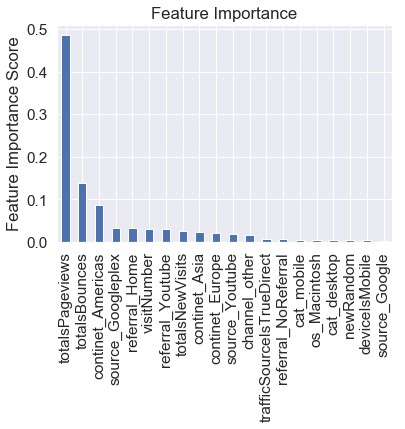

In [39]:
plot_feat_imp(rfc_best,20,df_downsampled.columns)

In [40]:
print_feat_imp(rfc_best,df_downsampled)

,Importance,Feature
0,0.4857,totalsPageviews
1,0.1379,totalsBounces
2,0.0862,continet_Americas
3,0.0341,source_Googleplex
4,0.0334,referral_Home
5,0.0315,visitNumber
6,0.0297,referral_Youtube
7,0.0264,totalsNewVisits
8,0.0239,continet_Asia
9,0.0212,continet_Europe


#### Permutation Importance

In [95]:
cols = ['channel_direct', 'channel_organic', 'channel_other', 'channel_paid',
       'browser_android', 'browser_chrome', 'browser_firefox',
       'browser_microsoft', 'browser_other', 'cat_desktop', 'cat_mobile',
       'os_Android', 'os_Macintosh', 'os_Windows', 'os_iOS', 'continet_Africa',
       'continet_Americas', 'continet_Asia', 'continet_Europe',
       'continet_Oceania', 'ad_GoogleMerchandiseCollection', 'ad_NoAd',
       'network_Google Search', 'network_NoAdWords', 'campaign_AW',
       'campaign_Data Share', 'campaign_NoCampaign', 'medium_affiliate',
       'medium_cpc', 'medium_cpm', 'medium_none', 'medium_organic',
       'medium_other', 'referral_Google', 'referral_Home',
       'referral_NoReferral', 'referral_Youtube', 'source_Google',
       'source_Googleplex', 'source_Youtube', 'source_direct', 'visitNumber',
       'deviceIsMobile', 'totalsBounces', 'totalsNewVisits', 'totalsPageviews',
       'adwordsClickGclId', 'trafficSourceIsTrueDirect', 'newRandom']

In [98]:
df_pi = eli5.formatters.as_dataframe.explain_weights_df(rfc_best, top=10, feature_names = cols)

In [99]:
df_pi

,feature,weight,std
0,totalsPageviews,0.485706,0.285402
1,totalsBounces,0.137896,0.146118
2,continet_Americas,0.086153,0.123887
3,source_Googleplex,0.034071,0.075819
4,referral_Home,0.033391,0.070197
5,visitNumber,0.031463,0.063735
6,referral_Youtube,0.029742,0.055369
7,totalsNewVisits,0.026429,0.055948
8,continet_Asia,0.023871,0.046973
9,continet_Europe,0.021236,0.037509


**CONCLUSIONS:**<br>
* The AUC, CM and F1 have given very good results.<br>
* The Pageviews, Bounces and the continent to be America have a 70% of importance in the model.<br>
* The column random is the 18th feature in importance, the rest of the columns can be avoided.

**IMPROVEMENTS:**<br>
* Improve the hyperparameter optimization of the model.
* Standarize the df to equal the vars range
* Take out the columns that perform under the random var